<a href="https://colab.research.google.com/github/Ludvins/VC/blob/master/Practica%202/Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [0]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import keras.utils as np_utils
# Import optimizer
from keras.optimizers import SGD
# Import data
from keras.datasets import cifar100
# Import models and layers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization, Conv1D, GlobalAveragePooling2D
# Import image proprocessors
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
# Import Resnet
from keras.applications.resnet50 import ResNet50, preprocess_input
# Import Early Stopping
from keras.callbacks import EarlyStopping
# Show no TensorFlow deprecation warnings
import tensorflow.compat.v1 as tf
tf.logging.set_verbosity(tf.logging.ERROR)

# Drive mount

Loads drive path

In [2]:
PATH = "/content/drive/My Drive/VC/"
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Clean drive folder and unzip data.

In [0]:
!rm -rf "/content/drive/My Drive/VC/images"
!rm -rf "/content/drive/My Drive/VC/lists"
!unzip -q "/content/drive/My Drive/VC/Caltech" -d "/content/drive/My Drive/VC"

# Data reading functions

## Cifar

Loads Cifar data.

In [0]:
def load_cifar_data():
    # Load Data
    (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

    # Transform to float and normalize
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    
    # We will use only 25 classes.
    train_idx = np.isin(y_train, np.arange(25))
    train_idx = np.reshape(train_idx, -1)
    x_train = x_train[train_idx]
    y_train = y_train[train_idx]
    test_idx = np.isin(y_test, np.arange(25))
    test_idx = np.reshape(test_idx, -1)
    x_test = x_test[test_idx]
    y_test = y_test[test_idx]
    
    # Set labels to cathegorical
    y_train = np_utils.to_categorical(y_train, 25)
    y_test = np_utils.to_categorical(y_test, 25)
    
    return x_train, y_train, x_test, y_test

## Caltech

Returns images and classes in `path_list`.







In [0]:
def read_img (paths_list):
    classes = np.array([path.split('/')[0] for path in paths_list])
    vim = np.array([img_to_array(load_img(PATH + "images/"+ im, target_size = (224,224,3))) 
                    for im in paths_list])

    return vim, classes

Reads `Caltech` data in `x_train`, `y_train`, `x_test` y `y_test`

In [0]:
def load_caltech_data():

    # Load files with paths
    train_path = np.loadtxt(PATH + "lists/train.txt", dtype = str)
    test_path = np.loadtxt(PATH + "lists/test.txt", dtype = str)

    # Read imgs
    print("Loading data...")
    x_train, y_train = read_img(train_path)
    x_test, y_test = read_img(test_path)
    print("Data loaded.")

    # Set classes to numerical
    unique_classes = np.unique(np.copy(y_train))
    for i in range(len(unique_classes)):
      y_train[y_train == unique_classes[i]] = i
      y_test[y_test == unique_classes[i]] = i

    # Set classes to categorical
    y_train = np_utils.to_categorical(y_train, 200)
    y_test = np_utils.to_categorical(y_test, 200)

    # Shuffle data
    x_train_perm = np.random.permutation(len(x_train))
    x_train = x_train[x_train_perm]
    y_train = y_train[x_train_perm]

    x_test_perm = np.random.permutation(len(x_test))
    x_test = x_test[x_test_perm]
    y_test = y_test[x_test_perm]

    return x_train, y_train, x_test, y_test

Preprocess caltech data to be used by ResNet.

In [0]:
def load_preprocessed_caltech_data():
  x_train, y_train, x_test, y_test = load_caltech_data()
  return preprocess_input(x_train), y_train, preprocess_input(x_test), y_test

# Functions for graphics

Draws two graphics.
+ Loss function evolution.
+ Accuracy function evolution.

Args:
+ ```hist```: Training records

In [0]:
def show_evolution(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training loss', 'Validation loss'])
    plt.show()
    
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training accuracy', 'Validation accuracy'])
    plt.show()

Draws the same graphics as ```show_evolution``` but using a list of records ```hist```.

In [0]:
def compare_evolution(hist, names):

    for i in hist:
        val_loss = i.history['val_loss']
        plt.plot(val_loss)

    plt.legend(["Validation loss " + names[i] for i in range(len(hist))])
    plt.show()

    for i in hist:
        val_acc = i.history['val_acc']
        plt.plot(val_acc)

    plt.legend(["Validation accuracy " + names[i] for i in range(len(hist))])
    plt.show()

# Data generators

In [0]:
def sample_data_generator():
  return ImageDataGenerator(
      featurewise_center = True,             # set input mean to 0 over the dataset
      samplewise_center = False,             # set each sample mean to 0
      featurewise_std_normalization = True,  # divide inputs by std of the dataset
      samplewise_std_normalization = False,  # divide each input by its std
      zca_whitening = False,                 # apply ZCA whitening
      zca_epsilon = 1e-06,                   # epsilon for ZCA whitening
      rotation_range = 0,                    # randomly rotate images in the range (degrees, 0 to 180)
      width_shift_range = 0.1,               # randomly shift images horizontally (fraction of total width)
      height_shift_range = 0.1,              # randomly shift images vertically (fraction of total height)
      shear_range = 0.,                      # set range for random shear
      zoom_range = 0.,                       # set range for random zoom
      channel_shift_range = 0.,              # set range for random channel shifts
      fill_mode = 'nearest',                 # set mode for filling points outside the input boundaries
      cval = 0.,                             # value used for fill_mode = "constant"
      horizontal_flip = True,                # randomly flip images
      vertical_flip = False,                 # randomly flip images
      rescale = None,                        # set rescaling factor (applied before any other transformation)
      preprocessing_function = None,         # set function that will be applied on each input
      data_format = None,                    # image data format, either "channels_first" or "channels_last"
      validation_split = 0.1)                # fraction of images reserved for validation (strictly between 0 and 1)

In [0]:
def train_data_generator_with_whitening():
  return ImageDataGenerator(
      featurewise_center = True,             
      zca_whitening = True,                 
      horizontal_flip = True,             
      validation_split = 0.1)                

In [0]:
def test_data_generator_with_whitening():
  return ImageDataGenerator(
      featurewise_center = True,             
      zca_whitening = True)   

In [0]:
def train_data_generator_without_whitening():
  return ImageDataGenerator(
      featurewise_center = True,             
      featurewise_std_normalization = True, 
      width_shift_range = 0.1,               
      height_shift_range = 0.1,              
      horizontal_flip = True,               
      validation_split = 0.1)              

In [0]:
def test_data_generator_without_whitening():
  return ImageDataGenerator(
      featurewise_center = True,             
      featurewise_std_normalization = True)  

# Model definitions

## BaseNet Model

In [0]:
def simple_base_net_model():
    model = Sequential()
    model.name = "Modelo BaseNet"
    model.add(Conv2D(6, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=(32,32,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, kernel_size=(5,5), 
                    activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(25, activation='softmax'))
    
    return model

In [0]:
def complex_base_net_model_no_norm():
    model = Sequential()
    model.name = "Modelo BaseNet sin BatchNormalization"
    model.add(Conv2D(32, (3, 3), padding='same', activation = 'relu', input_shape=(32,32,3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(25, activation='softmax'))

    return model

In [0]:
def complex_base_net_model_norm_after_relu():
    model = Sequential()
    model.name = "Modelo BaseNet con BatchNormalization despues de Activacion"
    model.add(Conv2D(32, (3, 3), padding='same', activation = 'relu', input_shape=(32,32,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(25, activation='softmax'))

    return model

In [0]:
def complex_base_net_model_norm_before_relu():
    model = Sequential()
    model.name = "Modelo BaseNet con BatchNormalization antes de Activacion"
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32,32,3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(25, activation='softmax'))

    return model

## Classifier Models

In [0]:
def basic_classifier_model():
  model = Sequential()

  model.name = "Clasificador Básico"
  model.add(Dense(200, activation='softmax', input_shape=(2048,)))
  return model

In [0]:
def two_layers_classifier_model():
  model = Sequential()

  model.name = "Clasificador Complejo"
  model.add(Dense(1024, activation='relu', input_shape=(2048,)))
  model.add(Dense(200, activation='softmax'))
  return model

In [0]:
def two_layers_dropout_classifier_model():
  model = Sequential()

  model.name = "Clasificador Complejo"
  model.add(Dense(1024, activation='relu', input_shape=(2048,)))
  model.add(Dropout(0.75))
  model.add(Dense(200, activation='softmax'))
  return model

## ResNet Model

In [0]:
def one_layer_resnet_model():
    resnet50 = ResNet50(weights='imagenet', include_top=False, pooling="avg", input_shape=(224,224,3))
    x = resnet50.output
    last = Dense(200, activation='softmax')(x)
    model = Model(inputs=resnet50.input, output = last)
      
    return model

In [0]:
def two_layers_resnet_model():
    resnet50 = ResNet50(weights='imagenet', include_top=False, pooling="avg", input_shape=(224,224,3))
    x = resnet50.output
    x = Dense(1024, activation='relu')(x)
    last = Dense(200, activation='softmax')(x)
    model = Model(inputs=resnet50.input, output = last)
      
    return model

In [0]:
def two_layers_conv_resnet_model():
    resnet50 = ResNet50(weights='imagenet', include_top=False, pooling=None, input_shape=(224,224,3))
    x = resnet50.output
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = Dropout(0.2)(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.4)(x)
    last = Dense(200, activation='softmax')(x)
    model = Model(inputs=resnet50.input, output = last)

    return model

# Training and evaluation function

Compiles the given model

In [0]:
def model_compile(model):
    model.compile(
        loss = keras.losses.categorical_crossentropy,
        optimizer = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True),
        metrics = ['accuracy']
    )

Fits the datagen given by `data_generator` to the given set.

In [0]:
def fitted_datagen(data_generator, x_train):
    datagen = data_generator()
    datagen.fit(x_train)

    return datagen

Fits the model using `train_datagen` if given.

In [0]:
def train(model, x_train, y_train, batch_size, epochs, train_datagen = None, verbose = 1, val_split = 0.1, shuffle = True):

    if (verbose != 0):
      print(" - ENTRENAMIENTO - ")

    if train_datagen is None:
      return model.fit(x_train, y_train, batch_size, epochs, verbose = verbose, validation_split = val_split, shuffle = shuffle)

    else:
      return model.fit_generator(
                generator = train_datagen.flow(x_train, y_train, batch_size, subset='training'),
                steps_per_epoch = len(x_train)*0.9/batch_size,
                epochs = epochs,
                validation_data = train_datagen.flow(x_train, y_train, batch_size, subset='validation'),
                validation_steps = len(x_train)*0.1/batch_size,
                verbose = verbose,
                callbacks = [EarlyStopping(monitor = 'val_acc', patience = 10, restore_best_weights = True)],
                shuffle = shuffle
                )

Evaluates the model using `train_datagen` if given.



In [0]:
def evaluate(model, x_test, y_test, test_datagen = None, verbose = 0):
    if (verbose != 0):
      print(" - RESULTADOS - ")
    if test_datagen is None:
      score = model.evaluate(x_test, y_test, verbose = verbose)
    else:
      score = model.evaluate_generator(
        generator = test_datagen.flow(x_test, y_test, 1),
        verbose = verbose
      )
    
    print('PÉRDIDA: ', score[0])
    print('PRECISIÓN: ', score[1])

Extracts features using the model and the`train_datagen` if given.



In [0]:
def extract_features(model, data, train_datagen = None, verbose = 1):

    if train_datagen is None:
      return model.predict(data, verbose = verbose)

    return model.predict_generator(
                generator = train_datagen.flow(data, batch_size = 1, shuffle = False),
                steps = len(data),
                )

# Test functions

## BaseNet & Cifar

In [57]:
cifar_train, cifar_train_labels, cifar_test, cifar_test_labels = load_cifar_data()

169009152/169001437 [==============================] - 11s 0us/step


--- APARTADO 1. ---
Model: "Modelo BaseNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 50)                20050     
_________________________________________________________________
dense_38 (Dense)             (No

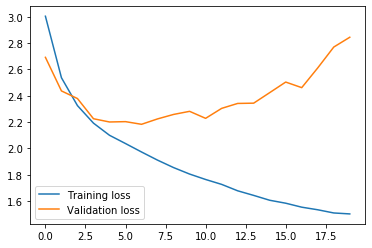

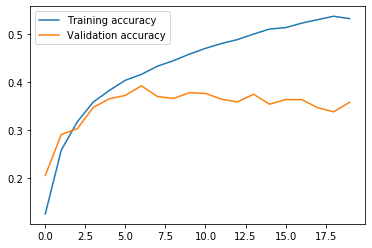

In [64]:
print("--- APARTADO 1. ---")
m = simple_base_net_model()
model_compile(m)
basic_model_weights = m.get_weights()
m.summary()

h = train(m, cifar_train, cifar_train_labels, 32, 20, verbose = 1)
evaluate(m, cifar_test, cifar_test_labels, verbose = 0)

print(" - GRÁFICAS - ")
show_evolution(h)

--- COMPARACIÓN DE GENERADORES ---
 - RESULTADOS SIN WHITENING - 
PÉRDIDA:  1.9068185174722398
PRECISIÓN:  0.432
 - RESULTADOS CON WHITENING - 
PÉRDIDA:  2.014278331503267
PRECISIÓN:  0.4304
 - GRÁFICAS COMPARATIVAS -


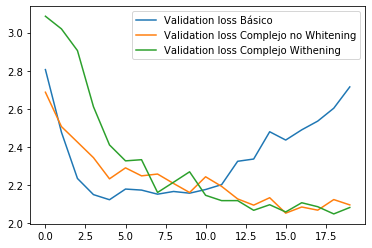

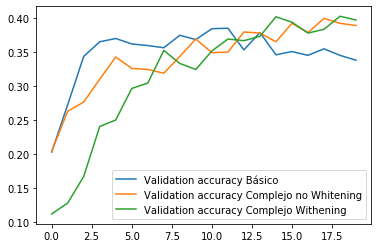

In [59]:
print("--- COMPARACIÓN DE GENERADORES ---")
print(" - RESULTADOS SIN WHITENING - ")
m.set_weights(basic_model_weights)

train_datagen = fitted_datagen(train_data_generator_without_whitening, cifar_train) 
test_datagen = fitted_datagen(test_data_generator_without_whitening, cifar_train)

h2 = train(m, cifar_train, cifar_train_labels, 32, 20, train_datagen, 0)
evaluate(m, cifar_test, cifar_test_labels, test_datagen, 0)

print(" - RESULTADOS CON WHITENING - ")
m.set_weights(basic_model_weights)

train_datagen = fitted_datagen(train_data_generator_with_whitening, cifar_train) 
test_datagen = fitted_datagen(test_data_generator_with_whitening, cifar_train)

h3 = train(m, cifar_train, cifar_train_labels, 32, 20, train_datagen, 0)
evaluate(m, cifar_test, cifar_test_labels, test_datagen, 0)

print(" - GRÁFICAS COMPARATIVAS -")
compare_evolution([h, h2, h3], ["básico", "complejo no whitening", "complejo whitening"])

 --- BASENET MODIFICADO SIN BATCHNORMALIZATION ---
Model: "Modelo BaseNet sin BatchNormalization"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 13, 13, 64)        36928     
____________________________________________

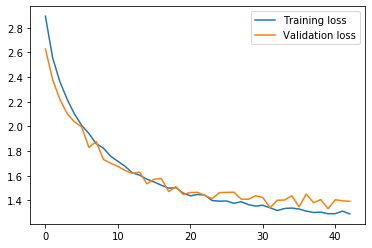

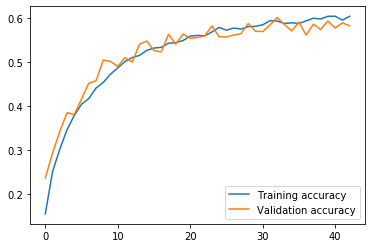

In [66]:
print(" --- BASENET MODIFICADO SIN BATCHNORMALIZATION ---")
m2 = complex_base_net_model_no_norm()
model_compile(m2)
m2.summary()
complex_model_weights = m2.get_weights()

train_datagen = fitted_datagen(train_data_generator_without_whitening, cifar_train)
test_datagen = fitted_datagen(test_data_generator_without_whitening, cifar_train)

h = train(m2, cifar_train, cifar_train_labels, 32, 100, train_datagen, 0)
evaluate(m2, cifar_test, cifar_test_labels, test_datagen, 0)
print(" - GRÁFICAS DE RESULTADOS - ")
show_evolution(h)

 --- BASENET MODIFICADO CON BATCHNORMALIZATION ANTES VS DESPUES --- 
 -- BATCHNORMALIZATION ANTES -- 
PÉRDIDA:  0.9689475336031279
PRECISIÓN:  0.6968
 - GRÁFICAS RESULTADOS - 


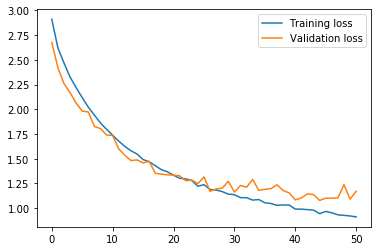

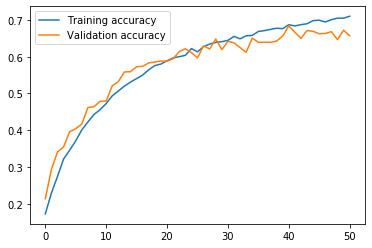

 -- BATCHNORMALIZATION DESPUÉS -- 
PÉRDIDA:  1.0282180929724063
PRECISIÓN:  0.6844
 - GRÁFICAS RESULTADOS - 


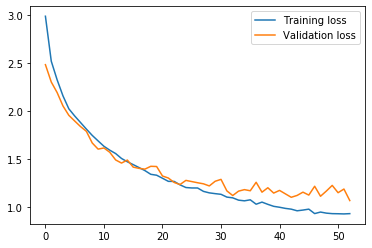

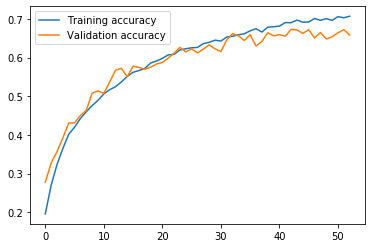

 - GRÁFICAS CONJUNTAS - 


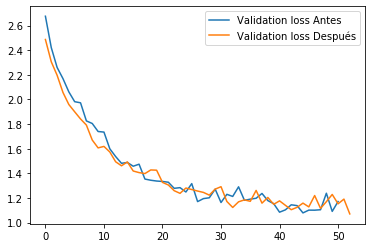

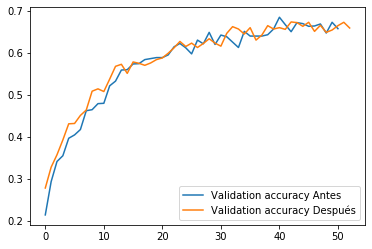

In [91]:
print(" --- BASENET MODIFICADO CON BATCHNORMALIZATION ANTES VS DESPUES --- ")
print(" -- BATCHNORMALIZATION ANTES -- ")
m3 = complex_base_net_model_norm_before_relu()
model_compile(m3)
#train_datagen, test_datagen = fit_generators(train_data_generator_without_whitening, test_data_generator_without_whitening, cifar_train)
h3 = train(m3, cifar_train, cifar_train_labels, 32, 100, train_datagen, 0)
evaluate(m3, cifar_test, cifar_test_labels, test_datagen, 0)
print(" - GRÁFICAS RESULTADOS - ")
show_evolution(h3)

print(" -- BATCHNORMALIZATION DESPUÉS -- ")
m4 = complex_base_net_model_norm_after_relu()
model_compile(m4)
#train_datagen, test_datagen = fit_generators(train_data_generator_without_whitening, test_data_generator_without_whitening, cifar_train)
h4 = train(m4, cifar_train, cifar_train_labels, 32, 100, train_datagen, 0)
evaluate(m4, cifar_test, cifar_test_labels, test_datagen, 0)
print(" - GRÁFICAS RESULTADOS - ")
show_evolution(h4)

print(" - GRÁFICAS CONJUNTAS - ")
compare_evolution([h3, h4], ["Antes", "Después"])

 -- BATCHNORMALIZATION DESPUÉS Y WHITENING -- 
PÉRDIDA:  1.1020758721511346
PRECISIÓN:  0.6764
 - GRÁFICAS RESULTADOS - 


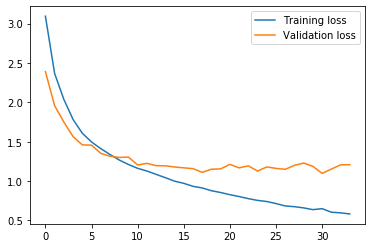

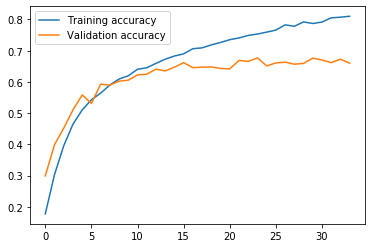

In [61]:
print(" -- BATCHNORMALIZATION DESPUÉS Y WHITENING -- ")
m5 = complex_base_net_model_norm_after_relu()
model_compile(m5)
train_datagen = fitted_datagen(train_data_generator_with_whitening, cifar_train) 
test_datagen = fitted_datagen(test_data_generator_with_whitening, cifar_train)

h = train(m5, cifar_train, cifar_train_labels, 32, 100, train_datagen, 0)
evaluate(m5, cifar_test, cifar_test_labels, test_datagen, 0)
print(" - GRÁFICAS RESULTADOS - ")
show_evolution(h)

## ResNet & Caltech

### Feature extractor

In [85]:
caltech_train, caltech_train_labels, caltech_test, caltech_test_labels = load_preprocessed_caltech_data()
resnet50 = ResNet50(weights='imagenet', include_top=False, pooling="avg", input_shape=(224,224,3))
caltech_train_features = extract_features(resnet50, caltech_train)
caltech_test_features = extract_features(resnet50, caltech_test)

Loading data...
Data loaded.
3033/3033 [==============================] - 8s 3ms/step


 --- RESNET EXTRACTOR DE CARACTERÍSTICAS --- 
 - ENTRENAMIENTO - 
Train on 2700 samples, validate on 300 samples
Epoch 1/20
2700/2700 [==============================] - 34s 13ms/step - loss: 4.3912 - acc: 0.1315 - val_loss: 3.1288 - val_acc: 0.2833
Epoch 2/20
2700/2700 [==============================] - 1s 248us/step - loss: 1.7493 - acc: 0.6007 - val_loss: 2.4210 - val_acc: 0.4100
Epoch 3/20
2700/2700 [==============================] - 1s 244us/step - loss: 0.9130 - acc: 0.8326 - val_loss: 2.1749 - val_acc: 0.4500
Epoch 4/20
2700/2700 [==============================] - 1s 239us/step - loss: 0.5489 - acc: 0.9274 - val_loss: 2.0651 - val_acc: 0.4600
Epoch 5/20
2700/2700 [==============================] - 1s 246us/step - loss: 0.3633 - acc: 0.9704 - val_loss: 1.9842 - val_acc: 0.4800
Epoch 6/20
2700/2700 [==============================] - 1s 246us/step - loss: 0.2588 - acc: 0.9856 - val_loss: 1.9319 - val_acc: 0.4867
Epoch 7/20
2700/2700 [==============================] - 1s 242us/step -

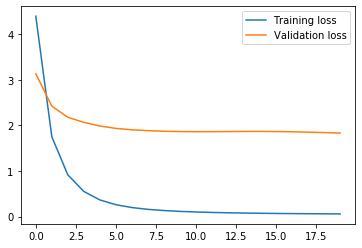

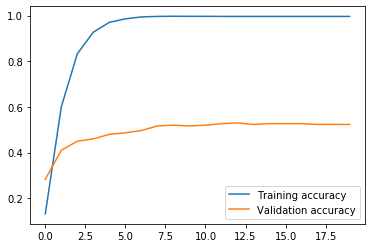

In [96]:
print(" --- RESNET EXTRACTOR DE CARACTERÍSTICAS --- ")
basic_classifier = basic_classifier_model()
model_compile(basic_classifier)
h = train(basic_classifier, caltech_train_features, caltech_train_labels, 32, 20, verbose=1)

evaluate(basic_classifier, caltech_test_features, caltech_test_labels)
show_evolution(h)

 --- RESNET EXTRACTOR DE CARACTERÍSTICAS MODELO 2 CAPAS --- 
PÉRDIDA:  2.5303809729260736
PRECISIÓN:  0.41971645237705396


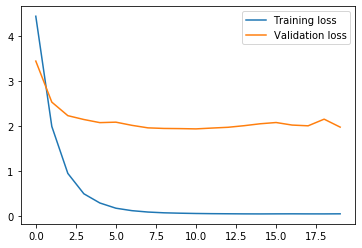

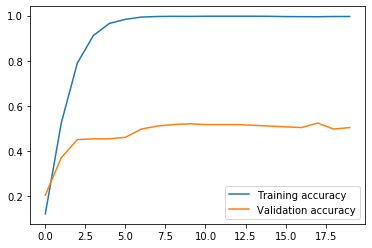

In [97]:
print(" --- RESNET EXTRACTOR DE CARACTERÍSTICAS MODELO 2 CAPAS --- ")
classifier = two_layers_classifier_model()
model_compile(classifier)
h2 = train(classifier, caltech_train_features, caltech_train_labels, 32, 20, verbose = 0)

evaluate(classifier, caltech_test_features, caltech_test_labels)
show_evolution(h2)

 --- RESNET EXTRACTOR DE CARACTERÍSTICAS MODELO COMPLEJO CON DROPOUT --- 
PÉRDIDA:  2.5000689025763196
PRECISIÓN:  0.39235080769264064


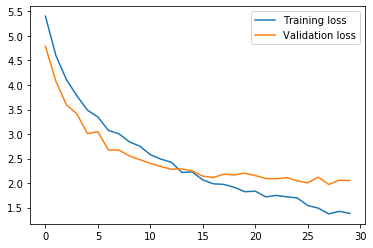

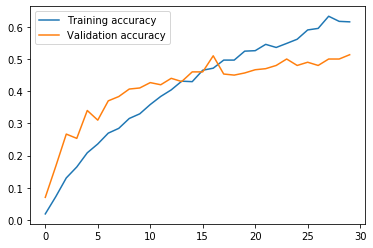

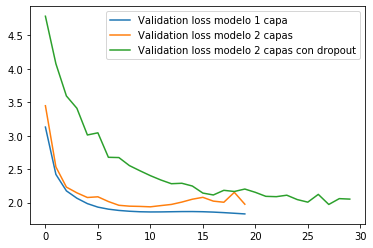

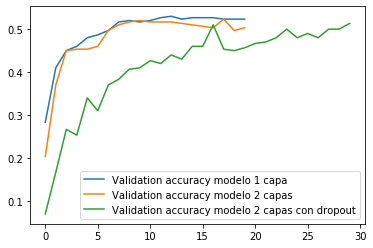

In [98]:
print(" --- RESNET EXTRACTOR DE CARACTERÍSTICAS MODELO COMPLEJO CON DROPOUT --- ")
classifier = two_layers_dropout_classifier_model()
model_compile(classifier)
h3 = train(classifier, caltech_train_features, caltech_train_labels, 32, 30, verbose = 0)

evaluate(classifier, caltech_test_features, caltech_test_labels)
show_evolution(h3)
compare_evolution([h, h2, h3], ["modelo 1 capa", "modelo 2 capas", "modelo 2 capas con dropout"])

### Fine-Tunning

 --- RESNET SIN CONGELAR CON UNA CAPA DENSA ---


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """


 - ENTRENAMIENTO - 
Train on 2700 samples, validate on 300 samples
Epoch 1/10
2700/2700 [==============================] - 57s 21ms/step - loss: 4.3472 - acc: 0.1337 - val_loss: 4.1426 - val_acc: 0.1300
Epoch 2/10
2700/2700 [==============================] - 20s 8ms/step - loss: 1.4598 - acc: 0.6404 - val_loss: 3.0096 - val_acc: 0.3433
Epoch 3/10
2700/2700 [==============================] - 20s 8ms/step - loss: 0.2774 - acc: 0.9533 - val_loss: 2.4690 - val_acc: 0.4267
Epoch 4/10
2700/2700 [==============================] - 20s 8ms/step - loss: 0.0606 - acc: 0.9900 - val_loss: 2.1203 - val_acc: 0.4867
Epoch 5/10
2700/2700 [==============================] - 20s 8ms/step - loss: 0.0241 - acc: 0.9959 - val_loss: 1.8519 - val_acc: 0.5467
Epoch 6/10
2700/2700 [==============================] - 20s 8ms/step - loss: 0.0121 - acc: 0.9985 - val_loss: 1.8192 - val_acc: 0.5633
Epoch 7/10
2700/2700 [==============================] - 20s 8ms/step - loss: 0.0052 - acc: 0.9993 - val_loss: 1.7874 - val

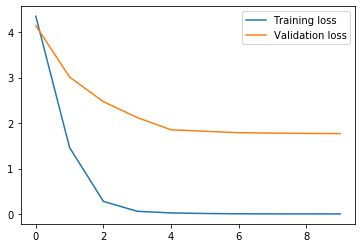

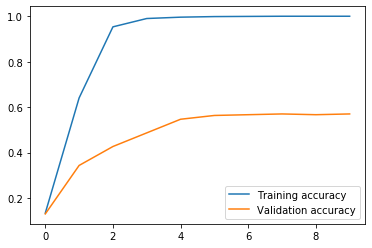

In [92]:
print(" --- RESNET SIN CONGELAR CON UNA CAPA DENSA ---")
m = one_layer_resnet_model()
model_compile(m)
h = train(m, caltech_train, caltech_train_labels, 32, 10, verbose=1)
evaluate(m, caltech_test, caltech_test_labels)

print(" - GRÁFICAS - ")
show_evolution(h)

 --- RESNET SIN CONGELAR CON DOS CAPA DENSAS ----


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


 - ENTRENAMIENTO - 
Train on 2700 samples, validate on 300 samples
Epoch 1/10
2700/2700 [==============================] - 42s 16ms/step - loss: 4.3676 - acc: 0.1211 - val_loss: 3.8005 - val_acc: 0.1400
Epoch 2/10
2700/2700 [==============================] - 20s 7ms/step - loss: 1.7170 - acc: 0.5696 - val_loss: 3.2621 - val_acc: 0.2367
Epoch 3/10
2700/2700 [==============================] - 20s 7ms/step - loss: 0.4337 - acc: 0.8981 - val_loss: 3.4438 - val_acc: 0.2833
Epoch 4/10
2700/2700 [==============================] - 20s 7ms/step - loss: 0.1688 - acc: 0.9607 - val_loss: 2.5553 - val_acc: 0.4133
Epoch 5/10
2700/2700 [==============================] - 20s 7ms/step - loss: 0.0644 - acc: 0.9852 - val_loss: 2.6360 - val_acc: 0.4300
Epoch 6/10
2700/2700 [==============================] - 20s 7ms/step - loss: 0.0251 - acc: 0.9948 - val_loss: 2.3051 - val_acc: 0.5000
Epoch 7/10
2700/2700 [==============================] - 20s 7ms/step - loss: 0.0073 - acc: 0.9985 - val_loss: 2.2887 - val

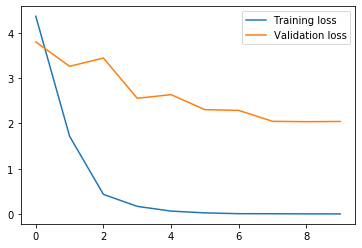

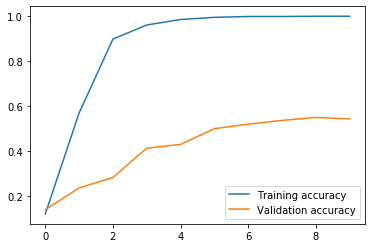

In [80]:
print(" --- RESNET SIN CONGELAR CON DOS CAPAS DENSAS ----")
m = two_layers_resnet_model()
model_compile(m)
#m.summary()
h = train(m, caltech_train, caltech_train_labels, 32, 10, verbose=1)
evaluate(m, caltech_test, caltech_test_labels)

print(" - GRÁFICAS - ")
show_evolution(h)

 --- RESNET SIN CONGELAR CON CONVOLUCION ----


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # Remove the CWD from sys.path while we load stuff.


 - ENTRENAMIENTO - 
Train on 2700 samples, validate on 300 samples
Epoch 1/10
2700/2700 [==============================] - 84s 31ms/step - loss: 5.2018 - acc: 0.0156 - val_loss: 4.8553 - val_acc: 0.0367
Epoch 2/10
2700/2700 [==============================] - 21s 8ms/step - loss: 4.4794 - acc: 0.0674 - val_loss: 4.4644 - val_acc: 0.0833
Epoch 3/10
2700/2700 [==============================] - 21s 8ms/step - loss: 3.7051 - acc: 0.1344 - val_loss: 3.9973 - val_acc: 0.0933
Epoch 4/10
2700/2700 [==============================] - 21s 8ms/step - loss: 3.0956 - acc: 0.2178 - val_loss: 4.2835 - val_acc: 0.1133
Epoch 5/10
2700/2700 [==============================] - 21s 8ms/step - loss: 2.5403 - acc: 0.3274 - val_loss: 3.8300 - val_acc: 0.1667
Epoch 6/10
2700/2700 [==============================] - 21s 8ms/step - loss: 2.0578 - acc: 0.4330 - val_loss: 3.6763 - val_acc: 0.1967
Epoch 7/10
2700/2700 [==============================] - 21s 8ms/step - loss: 1.7233 - acc: 0.5211 - val_loss: 4.4109 - val

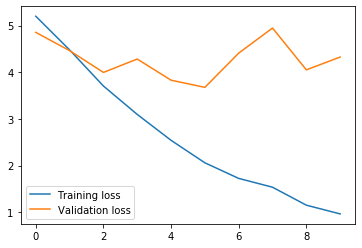

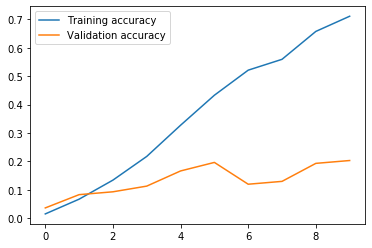

In [131]:
print(" --- RESNET SIN CONGELAR CON CONVOLUCION ----")
m = two_layers_conv_resnet_model()
model_compile(m)
h = train(m, caltech_train, caltech_train_labels, 32, 10, verbose=1)
evaluate(m, caltech_test, caltech_test_labels)

print(" - GRÁFICAS - ")
show_evolution(h)